# Predicting Reservoir Storage

## Introduction

California has one of the most complex water systems in the world. With a population of nearly 40 million residents and the largest agricultural economy of any state, water management has become key to keeping the state running. However, the state has faced increasing water uncertainty as climate change destabilizes annual rainfall and increases temperatures. Droughts have also increased and intensified. The snowpack and its spring melt has shrank significantly in the past 2 decades, causing water shortages.

Predicting water storage has been a key goal for California policymakers to determine allocations to farmers, municipalities, and industry, as well as environmental objectives such as maintaining fish populations. While California's policymakers and researchers have come up with prediction bencharks, machine-learning approaches have not been used before. This novel style could allow for future research.



## Project Summary

My project's goal is to model and predic reservoir water levels in California. Using a previous years temperature and precipitation data, I hoped to see how accurately I could predict reservoir capacity and provide a range of possible values, not given the current water year data.

This project is of utmost importance given California's intensifying climate crisis. For my process of data analysis and model training, I use Folsom Lake, the 10th largest dam in California and a key water supply for millions of its residents. For personal context, I grew up in Sacramento by Folsom Lake. It is going increasingly deep in its reserves during the extending droughts, having got to as low as 14% of its capacity in 2014. 

My goal was to create a model that could use exogenous seasonal variables to predict seasonal water supply and its annual minimum. Once I trained and tested on Folsom Lake, I would be able to expand and test the model on other Sacramento River watershed reservoirs and then work south on San Joaquin River watersheds. With these models trained on older data, I can predict on the 2021 water year, which ended this September 30th.

Time series models that made the most sense for this were seasonal and auto-regressive. I performed a gridsearch to find the best paramters for SARIMS and compaed it to a naive model, which assumes that the water level will be the exct same a year ago as water levels are a yearly cycle. I then add in exogenous variables and compare this with the solely endogenous SARIMA model.



In [26]:
#import libraries
! pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import auto_arima, decompose

from functools import reduce
import itertools

     |████████████████████████████████| 595 kB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 16.9 MB 98.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 42.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the 

## Data Understanding

To predict Folsom Lake's water storage, we can take daily data from the US Bureau of Reclamation. The bureau has extensive time series datasets going back into vthe early 1900's on most major reseroirs in the country, There is also an exogenous variable of interest which could help in predictions: the daily evaporation is available for each reservoir. Other variables I could pull from the site include daily release, precipitation, inflow, and water level by height; however, I decided to go with other sources for weather data.


While some of the originl datasets are daily, my computer does not have the capacity to handle the computations for 365 period of seasonal data. So we grouped up data into monthly chunks.

In [2]:
storage = pd.read_csv('data/folsomlake/folsom_storage.csv',header=7) #acre feet
evaporation = pd.read_csv('data/folsomlake/folsom_evaporation.csv',header=7) #sum cfs 24 hr

print(storage.head())
print(evaporation.head())

                         Location               Parameter  Result Units  \
0  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  569846    af   
1  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  568275    af   
2  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  566879    af   
3  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  564963    af   
4  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  562713    af   

  Timestep Aggregation       Datetime (UTC)  
0    daily     instant  1989-10-01 08:00:00  
1    daily     instant  1989-10-02 08:00:00  
2    daily     instant  1989-10-03 08:00:00  
3    daily     instant  1989-10-04 08:00:00  
4    daily     instant  1989-10-05 08:00:00  
                         Location                   Parameter  Result Units  \
0  Folsom Lake Dam and Powerplant  Lake/Reservoir Evaporation   42.23   cfs   
1  Folsom Lake Dam and Powerplant  Lake/Reservoir Evaporation   42.17   cfs   
2  Folsom Lake Dam and Powerplant  L

Because rain and temperature conditions are a key part of predicting watershed health and droughts (https://www.usgs.gov/special-topic/water-science-school/science/droughts-things-know?qt-science_center_objects=0#qt-science_center_objects), I decided to incorporate comprehensive data that could cover the true health of the watersheds each season. 

The California Data Exchange Center has time series data provided by the California Department of Water resources. I chose two datasets for precipitation levels.

The 8-station Sierra Index tracks precipitation across the Northern Sierras, and is an accurate measure of the water coming into the Sacramento River watershed. The Sacramento River watershed is the largest watershed in California, and contains many of the key reservoirs we will be modelling.

Meanwhile, the 5-station Sierra Index tracks precipitation in the Southern Sierras, and is a measure of the water year of the San Joaquin River watershed, the second largest watershed in the state.

I downloaded these to utilize as an exogenous variable. Both datasets are monthly.

In [3]:
northsierra = pd.read_csv('data/8SI.csv')
southsierra = pd.read_csv('data/5SI.csv')

In [4]:
print(northsierra.head())
print(southsierra.head())

   Unnamed: 0  Monthly  Annual
0  1990-10-31     1.10   32.17
1  1990-11-30     1.56   32.17
2  1990-12-31     1.39   32.17
3  1991-01-31     0.88   32.17
4  1991-02-28     3.11   32.17
  STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE  DATE TIME  OBS DATE  VALUE  \
0        5SI        M              2      RAIN        NaN  19900101   5.60   
1        5SI        M              2      RAIN        NaN  19900201   4.69   
2        5SI        M              2      RAIN        NaN  19900301   3.09   
3        5SI        M              2      RAIN        NaN  19900401   2.32   
4        5SI        M              2      RAIN        NaN  19900501   3.16   

   ANNUAL DATA_FLAG   UNITS  
0     NaN            INCHES  
1     NaN            INCHES  
2     NaN            INCHES  
3     NaN            INCHES  
4     NaN            INCHES  


### Data Preprocessing

I edited the dataframes so they can be interpreted as time series and have matching start and end dates is crucial to our modelling. As water years begin October 1st each year, we will starting in October 1st 1990 and ending September 30th 2020, the end of the 2021 water year.

In [5]:
#drop unnecessary columns

drop_list = ['Location','Parameter','Timestep','Aggregation','Units']

storage.drop(drop_list,axis=1,inplace=True)
evaporation.drop(drop_list,axis=1,inplace=True)

#rename for clarity
storage.rename(columns= {'Result': 'storage'},inplace=True)
evaporation.rename(columns= {'Result': 'evaporation'},inplace=True)

In [6]:
#adjust dates to water year
start_date = "1990-10-01"
end_date = "2021-10-01"

storage = storage[(storage['Datetime (UTC)'] >= start_date) & (storage['Datetime (UTC)'] <= end_date)]

evaporation = evaporation[(evaporation['Datetime (UTC)'] >= start_date) & (evaporation['Datetime (UTC)'] <= end_date)]

#rename columns
storage['date']= pd.to_datetime(storage['Datetime (UTC)']).dt.date
evaporation['date']= pd.to_datetime(evaporation['Datetime (UTC)']).dt.date
storage.drop('Datetime (UTC)',axis=1,inplace=True)
evaporation.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
storage.set_index('date',inplace=True)
evaporation.set_index('date',inplace=True)

#set index to datetime format

storage.index = pd.to_datetime(storage.index)
evaporation.index = pd.to_datetime(evaporation.index)

In [7]:
#convert north sierra and south sierra indices to time series data
northsierra.rename({'Unnamed: 0':'date'},axis=1,inplace=True)
northsierra['date'] = pd.to_datetime(northsierra['date'])
northsierra.set_index('date',inplace=True)

#clean south sierra set to just the necessary info
drop_list = ['STATION_ID','DURATION','SENSOR_NUMBER','SENS_TYPE','DATE TIME','DATA_FLAG','UNITS']
southsierra.drop(drop_list,axis=1,inplace=True)

southsierra['OBS DATE'] = southsierra['OBS DATE'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

southsierra = southsierra[(southsierra['OBS DATE'] >= start_date) & (southsierra['OBS DATE'] <= end_date)]


southsierra.rename({'OBS DATE':'date'},axis=1,inplace=True)
southsierra.set_index('date',inplace=True)

The time series machine learning models will struggle to handle the number of time periods if we do not aggregrate up from daily data, so I did that below.

In [8]:
#aggregate data to monthly

storage = storage.resample('1M').mean().round(2)
evaporation = evaporation.resample('1M').mean().round(2)

southsierra = southsierra.resample('1M').sum().round(2)
northsierra = northsierra.resample('1M').sum().round(2)

In [9]:
#drop unneeded extra rows
northsierra.drop([pd.to_datetime('2021-10-31'),pd.to_datetime('2021-11-30')],inplace=True)
southsierra.drop(pd.to_datetime('2021-10-31'),inplace=True)

Since Folsom Lake is a part of the Sacramento Valley watershed, we are going to do a merge on the storage and evaporation datasets with the northern sierra precipitation dataset.

In [10]:
df_list = [northsierra ,evaporation,storage]

data = reduce(lambda left,right: pd.merge(left,right,on=['date'],how='outer'),df_list)

data

,Monthly,Annual,evaporation,storage
date,,,,
1990-10-31,1.10,32.17,22.63,176659.29
1990-11-30,1.56,32.17,9.90,166494.97
1990-12-31,1.39,32.17,4.27,162634.00
1991-01-31,0.88,32.17,6.08,156479.32
1991-02-28,3.11,32.17,8.56,163080.11
...,...,...,...,...
2021-05-31,0.18,23.20,67.03,366416.48
2021-06-30,0.08,23.20,73.73,328650.80
2021-07-31,0.08,23.20,59.77,262166.35


# Exploratory Data Analysis
The majority of our analysis centers around storage, the target variable. We notice how the data variance rapidly shifted from the 1990's onwards. This makes sense as California's climate has increasingly destabilized, resulting in more need for reservoir water.

### Plotting the target and exogenous variables

An important note for all the below graphs is that the tick marks correspond to actual years, not water years. So a tick mark of 2015 is January 1st 2015, not October 1st 2014.

As seen in the storage data below, water storage peaks during the spring melt and troughs before the rain season begins in November.

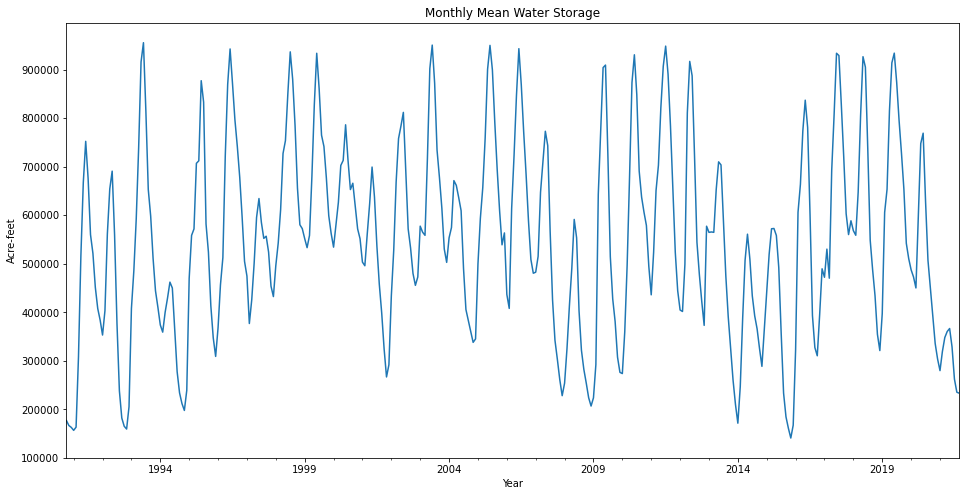

In [14]:
data.storage.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Monthly Mean Water Storage')
plt.show();

Below, we can see that evaporation is high in the summers, especially in heat waves, and drops to near nothing in the winters. This is valuable for predicting water storage given its correlation to temperature nd its sizeable impact on reservoir levels.

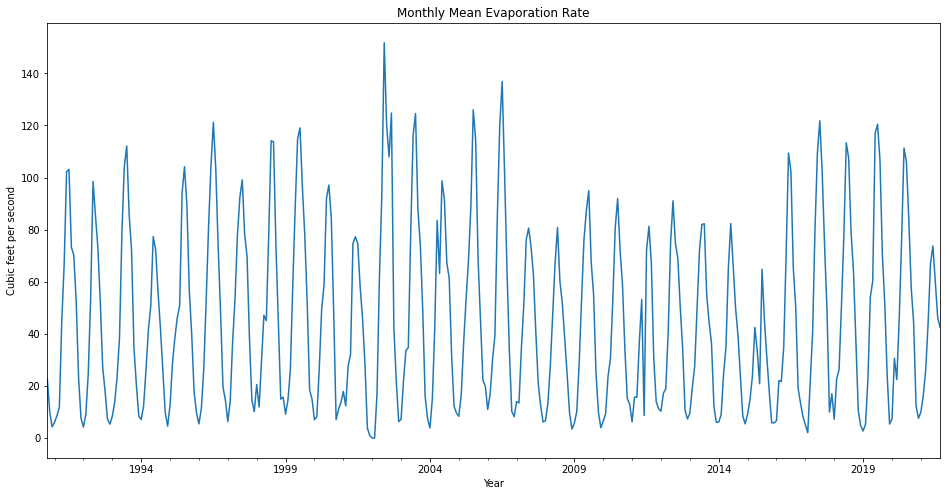

In [15]:
#plot average cfs evaporation per month

data.evaporation.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Cubic feet per second')
plt.title('Monthly Mean Evaporation Rate')
plt.show();

Below, we see how increasingly variable annual rainfall is. We can see its correlation to reservoir levels especially in the past couple years, 2019-2021, when a new drought began. The above reservoir storage also bottoms and doesn't recover.

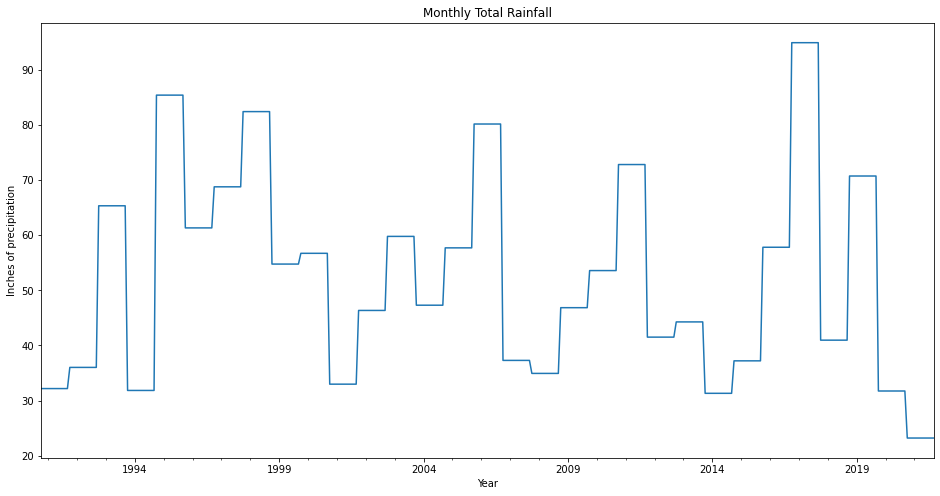

In [16]:
#plot annual rainfall

data.Annual.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Inches of precipitation')
plt.title('Annual Total Rainfall')
plt.show();

The below graph demonstrates the variability of California's climate but also affirms how important the winter rainfall season is. While varying in start date, winter is always the most time of rainfall.

<AxesSubplot:xlabel='date'>

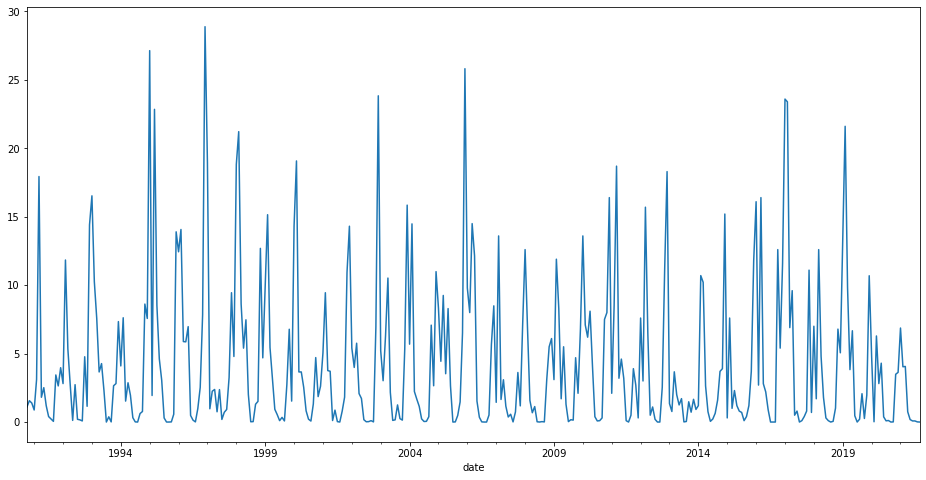

In [17]:
#plot monthly rainfall

data.Monthly.plot(figsize=(16,8))

### Examining the target's autocorrelation

Below, we see the strong seasonal correlation every 12 months. This correlation is significant even decades after measurement, shown by the fact the curve goes above the dotted line even past 250 months.

In [ ]:
fig, ax1 = plt.subplots(figsize = (16,8))

pd.plotting.autocorrelation_plot(data['storage'],ax=ax1)
plt.show();

In [ ]:
plot_acf(data['storage'],lags=12);

In [ ]:
result = seasonal_decompose(pd.Series(data['storage']),model='additive', period=12)

result.plot()
plt.show();

The two lag plots below confirm that there is a positively linear correlation between the storage data a month and a year after. The y+1 is much stronger than the y+12.

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
pd.plotting.lag_plot(data['storage'],ax=ax1,lag=1)
pd.plotting.lag_plot(data['storage'],ax=ax2,lag=12)
plt.show();

## Testing for Stationarity

For modelling to be accurate, we need to test for stationarity. We will do this using the Augmented Dickey Fuller Test. The null hypothesis is that the data is non-stationary. 

In [18]:
result = adfuller(data['storage'])
result


(-4.152984770686234,
 0.0007906198494945792,
 12,
 359,
 {'1%': -3.4486972813047574,
  '5%': -2.8696246923288418,
  '10%': -2.571077032068342},
 8825.854266739725)

Because the p-value is .0007, we can confidently reject the null hypothesis. The data is therefore stationary.

# Modelling
Our goal is to find a model that can most accurately predict the 2020 water year reservoir storage based on past years data. To recap, water years run from October 1st to September 30th each year. We will test the value of using exogenous variables versus using an autoregressive, seasonal, and moving average model. 

As hinted above, I initially tried running a SARIMA model on daily data; but having 365 periods of data to run through per season was too computationally expensive. Thus we run all models like our data is, with 12 periods per season. 

## Creating the Train and Test Sets

In [21]:
#20 years of data to train
train_start, train_stop = '1990-10-01','2019-10-01'

#1 year for testing
test_start, test_stop = '2019-10-01', '2020-10-01'

#create train and 
train, test = data[train_start:train_stop], data[test_start:test_stop]

#create separate target and exogenous variable sets
X= data.drop('storage',axis=1,inplace=False)
y= data['storage']

X_train, X_test = X[train_start:train_stop], X[test_start:test_stop]
y_train, y_test = y[train_start:train_stop], y[test_start:test_stop]

print(test)

            Monthly  Annual  evaporation    storage
date                                               
2019-10-31     0.26   31.73        51.39  653416.03
2019-11-30     1.97   31.73        24.00  542141.93
2019-12-31    10.69   31.73         5.35  510450.68
2020-01-31     4.81   31.73         7.29  487421.52
2020-02-29     0.02   31.73        30.66  472678.55
2020-03-31     6.29   31.73        22.42  450046.26
2020-04-30     2.81   31.73        45.67  596788.93
2020-05-31     4.30   31.73        76.06  747746.10
2020-06-30     0.38   31.73       111.33  769089.07
2020-07-31     0.09   31.73       105.97  628340.87
2020-08-31     0.11   31.73        83.58  507140.26
2020-09-30     0.00   31.73        57.47  449203.07


### Naive Model
The basic model predicts that the data is the same as last years, as the reservoir's ebb and flow is seasonal. So we use a lag of 12 months to predict the 2020 season.

In [22]:
#use test set copy for its datetime index
pred_naive = test.copy()

train_len = len(y_train)

#take the true values of the 2019 water year and input them as the naive prediction for the 2020 year
pred_naive.storage['2019-10-31':'2020-09-30'] = train.storage[train_len-12:train_len]

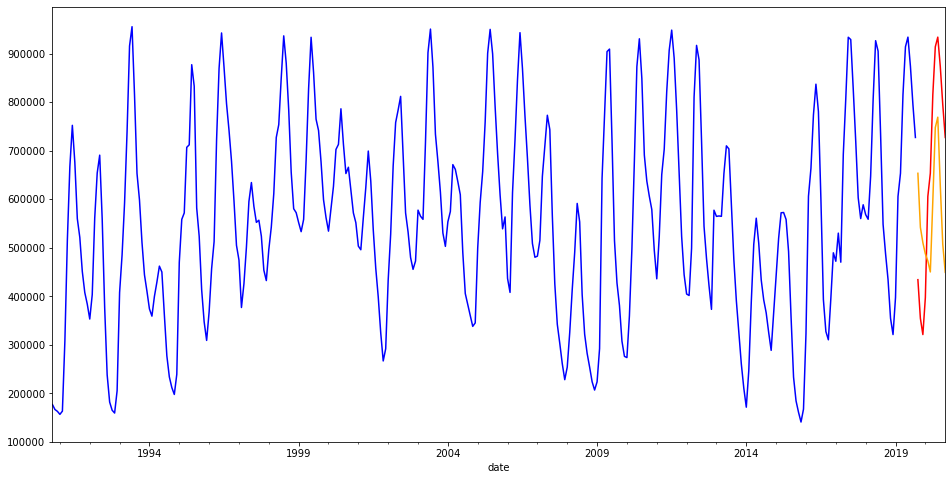

In [23]:
fig,ax = plt.subplots(figsize=(16,8))
train.storage.plot(ax=ax,color='blue')
pred_naive.storage.plot(ax=ax,color='red')
test.storage.plot(ax=ax,color='orange')
plt.show();

From above, we can see the discrepency between predicted(red) and actual(orange). To formalize this, we can calculate RMSE and MAE to compare the improvement of models moving forwards.

In [ ]:
rmse_naive = np.sqrt(mean_squared_error(pred_naive.storage,test.storage)).round(2) 
mae_naive = mean_absolute_error(pred_naive.storage,test.storage).round(2)

print('Naive model RMSE: ', rmse_naive, ' ; Naive model MAE', mae_naive)

## Building an initial seasonal model

In order to predict 12 months in advance, we can use lagged data in the SARIMA model. This model only uses past data of the storage levels. We use PMDArima's built in grid-search function to find the best paramaters for SARIMA. With the limitations, we find that a SARIMA model with p,d,q= (3,1,2) and P,D,Q= (0,1,1) the strongest. We set the mode to 12 as the season is a year for monthly data.

In [27]:
sarima_model = auto_arima(y_train,start_p=0,d=1,start_q=0,
          max_p=3,max_d=3,max_q=3, start_P=0,
          D=1, start_Q=3, max_P=3,max_D=3,
          max_Q=3, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8590.440, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8435.373, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=8390.175, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=8531.325, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=8391.028, Time=0.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=8391.184, Time=0.69 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=8431.908, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=8392.703, Time=0.96 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=8390.554, Time=0.23 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=8388.490, Time=0.24 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=8533.228, Time=0.05 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=8388.955, Time=0.38 sec
 ARIMA(0,1,2)(0,1,2)[12]     

In [28]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -4182.217
Date:                              Fri, 03 Dec 2021   AIC                           8378.435
Time:                                      22:03:27   BIC                           8405.133
Sample:                                           0   HQIC                          8389.079
                                              - 348                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5535      1.210      0.457      0.647      -1.819       2.926
ar.L2          0.5154      1.585      0.325      0.745      -2.590       3.621
ar.L3         -0.3031      0.577     -0.525      0.600      -1.435       0.829
ma.L1         -0.1853      1.194     -0.155      0.877      -2.526       2.155
ma.L2         -0.7200      1.116     -0.645      0.519      -2.908       1.467
ma.S.L12      -0.8355      0.074    -11.340      0.000      -0.980      -0.691
sigma2      6.387e+09   9.73e-11   6.56e+19      0.000    6.39e+09    6.39e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               144.41
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.86
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.41e+36. Standard errors may be unstable.
"""

## Incorporating exogenous models

We can now run a gridsearch with the whole exogenous and endogenous variable set in train. We have to set up our own model grid search as no library contains the functionality to compare time series models with exogenous paramaters. We find that the AIC is ___ than the purely endogenous SARIMA model, so we ____.

In [29]:
#set up gridsearch

#pdq are the ARMA potential paramaters
p = d = q = range(0,3)

arma_param_options = list(itertools.product(p,d,q))
arma_param_options


#creating pdq for the seasonal potential paramaters, 12 for the seasonal gap
seasonal_param_options = [(x[0],x[1],x[2],12) for x in arma_param_options]
seasonal_param_options

ValueError: y should be a 1d array, got an array of shape (348, 4) instead.

## Model Comparison

# Expanding the Model to Other Dams in California

## Northern Sierra / Sacramento Watershed Reservoirs

### Oroville

### Trinity Lake

### Lake Berryasa

### Shasta Lake

## San Joaquin Watershed Reservoirs


### Don Pedro

### Exchequer

### New Melones

### Pine Flat

### Millerton

# References

1. https://escholarship.org/uc/item/6hq949t6
2. https://data.usbr.gov/time-series/search?v=1
3. https://www.usgs.gov/special-topic/water-science-school/science/droughts-things-know?qt-science_center_objects=0#qt-science_center_objects
4. https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0